In [56]:
import glob
import rioxarray as rx
import xarray as xr
import pandas as pd
import numpy as np

In [2]:
path = '../../Data/originals/vgpm/untar/vgpm.2002182.hdf'
s = rx.open_rasterio(path, masked=True, parse_coordinates=True)[0]
s

/opt/homebrew/Caskroom/miniforge/base/envs/oparcels/lib/python3.12/site-packages/rioxarray/_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore


<xarray.DataArray (y: 1080, x: 2160)> Size: 9MB
[2332800 values with dtype=float32]
Coordinates:
    band         int64 8B 1
  * x            (x) float64 17kB 0.5 1.5 2.5 ... 2.158e+03 2.158e+03 2.16e+03
  * y            (y) float64 9kB 0.5 1.5 2.5 ... 1.078e+03 1.078e+03 1.08e+03
    spatial_ref  int64 8B 0
Attributes: (12/22)
    Central_Azimuth:      0
    Hole Value:           -9999
    Intercept:            0
    Isotropic:            0
    Latitude Center:      0
    Limit:                -90, -180, 90, 180
    ...                   ...
    Start Time String:    07/01/2002 00:00:00
    Stop Time:            1028185199
    Stop Time String:     07/31/2002 23:59:59
    Units:                mgC m-2 day-1
    scale_factor:         1.0
    add_offset:           0.0

In [57]:
file_pattern = '../../Data/originals/vgpm/untar/vgpm.*.hdf'
file_list = glob.glob(file_pattern)

In [58]:
dataarrays = []

for path in file_list:
    year = int(path[-11:-7])
    day_of_year = int(path[-7:-4])
    date = pd.to_datetime(f'{year}-{day_of_year}', format='%Y-%j')
    
    file = rx.open_rasterio(path, masked=True, parse_coordinates=True)[0]
    file = file.expand_dims(date=[date])
    file = file.rename({'x': 'lon', 'y':'lat'})
    file = file.where(file != -9999., other=np.nan)
    
    dataarrays.append(file)

/opt/homebrew/Caskroom/miniforge/base/envs/oparcels/lib/python3.12/site-packages/rioxarray/_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
/opt/homebrew/Caskroom/miniforge/base/envs/oparcels/lib/python3.12/site-packages/rioxarray/_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
/opt/homebrew/Caskroom/miniforge/base/envs/oparcels/lib/python3.12/site-packages/rioxarray/_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
/opt/homebrew/Caskroom/miniforge/base/envs/oparcels/lib/python3.12/site-packages/rioxarray/_io.py:1132: NotGeore

In [60]:
c_da = xr.concat(dataarrays, dim='date')
# 모든 월의 타임 스탬프 생성
all_months = pd.date_range(c_da.date.values.min(), c_da.date.values.max(), freq='MS')

# 누락된 월을 찾아서 DataArray에 추가
missing_months = [month for month in all_months if month not in c_da.date.values]
for month in missing_months:
    nan_data = xr.DataArray(np.full((1, 1080, 2160), np.nan), coords=[np.array([month]), c_da.lat.values, c_da.lon.values], dims=['date', 'lat', 'lon'])
    c_da = xr.concat([c_da, nan_data], dim='date')

c_da = c_da.sortby('date')
c_da = c_da.drop_vars('band')
c_da = c_da.drop_vars('spatial_ref')

#npp 오른쪽 상단([0,0])데이터가 +90, -180임
npp_shape = (1080, 2160) #lat, lon

#그럼 반 쪼갈 해서 뒤로 붙이면 되겠지?
index_half = npp_shape[1]//2
p1 = c_da[:,:,index_half:]
p2 = c_da[:,:,:index_half]

npp_lat = np.flip(np.linspace(0, 180, npp_shape[0])-90) #1080
npp_lon = np.linspace(0, 360, npp_shape[1], endpoint=False)#2160

cc_da = xr.concat([p1, p2], dim='lon')
cc_da = cc_da.assign_coords(lon=npp_lon, lat=npp_lat)
cc_da.name = 'vgpm'

In [55]:

all_months = pd.date_range(c_da.date.values.min(), c_da.date.values.max(), freq='MS')
if all_months[0] in c_da.date.values : print("yes")

yes


In [61]:
cc_da

<xarray.DataArray 'vgpm' (date: 253, lat: 1080, lon: 2160)> Size: 5GB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * date     (date) datetime64[ns] 2kB 2002-07-01 2002-08-01 ... 2023-07-01
  * lon      (lon) float64 17kB 0.0 0.1667 0.3333 0.5 ... 359.5 359.7 359.8
  * lat      (lat) float64 9kB 90.0 89.83 89.67 89.5 ... -89.67 -89.83 -90.0
Attributes: (12/22)
    Central_Azimuth:      0
    Hole Value:           -9999
    Intercept:            0
    Isotropic:            0
    Latitude Center:      0
    Limit:                -90, -180, 90, 180
    ...                   ...
    Start Time String:    09/01/2004 00:00:00
    Stop Time:            1096613999
    Stop Time String:     09/30/2004 23:59:59
    Units:                mgC m-2 day-1
    scale_factor:         1.0
    add_offset:           0.0

In [62]:
cc_da

<xarray.DataArray 'vgpm' (date: 253, lat: 1080, lon: 2160)> Size: 5GB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * date     (date) datetime64[ns] 2kB 2002-07-01 2002-08-01 ... 2023-07-01
  * lon      (lon) float64 17kB 0.0 0.1667 0.3333 0.5 ... 359.5 359.7 359.8
  * lat      (lat) float64 9kB 90.0 89.83 89.67 89.5 ... -89.67 -89.83 -90.0
Attributes: (12/22)
    Central_Azimuth:      0
    Hole Value:           -9999
    Intercept:            0
    Isotropic:            0
    Latitude Center:      0
    Limit:                -90, -180, 90, 180
    ...                   ...
    Start Time String:    09/01/2004 00:00:00
    Stop Time:            1096613999
    Stop Time String:     09/30/2004 23:59:59
    Units:                mgC m-2 day-1
    scale_factor:         1.0
    add_offset:           0.0

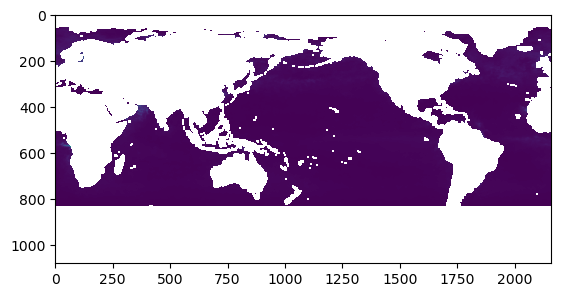

In [63]:
import matplotlib.pyplot as plt

plt.imshow(cc_da[0,:,:])

In [64]:
cc_da.to_netcdf('../../Data/originals/vgpm.nc')

In [44]:
t=xr.open_dataarray('../../Data/originals/good_vgpm.nc')
t

<xarray.DataArray (date: 252, lat: 1080, lon: 2160)> Size: 2GB
[587865600 values with dtype=float32]
Coordinates:
  * date     (date) datetime64[ns] 2kB 2002-07-01 2002-08-01 ... 2023-07-01
  * lon      (lon) float64 17kB 0.0 0.1667 0.3333 0.5 ... 359.5 359.7 359.8
  * lat      (lat) float64 9kB 90.0 89.83 89.67 89.5 ... -89.67 -89.83 -90.0
Attributes: (12/20)
    Central_Azimuth:      0
    Hole Value:           -9999
    Intercept:            0
    Isotropic:            0
    Latitude Center:      0
    Limit:                -90, -180, 90, 180
    ...                   ...
    Source:               not specified
    Start Time:           1094022000
    Start Time String:    09/01/2004 00:00:00
    Stop Time:            1096613999
    Stop Time String:     09/30/2004 23:59:59
    Units:                mgC m-2 day-1

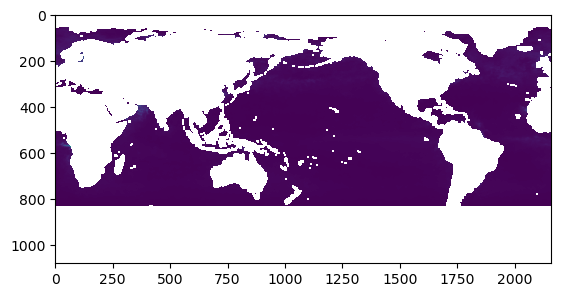

In [45]:
plt.imshow(t[0,:,:])


In [28]:
1/6

0.16666666666666666

In [6]:
xr.open_dataarray('../../Data/originals/npp_fixedgrid.nc')

<xarray.DataArray 'npp' (time: 240, latitude: 1080, longitude: 2160)> Size: 4GB
[559872000 values with dtype=float64]
Coordinates:
  * time       (time) datetime64[ns] 2kB 2003-01-01 2003-02-01 ... 2022-12-01
  * longitude  (longitude) float64 17kB 0.0 0.1667 0.3333 ... 359.5 359.7 359.8
  * latitude   (latitude) float64 9kB -90.0 -89.83 -89.67 ... 89.67 89.83 90.0
Attributes:
    Latitude Center:   0
    Limit:             -90, -180, 90, 180
    Longitude Center:  0
    Units:             mgC m-2 day-1

In [9]:
xr.open_dataarray('../../Data/originals/fixgrid_vgpm.nc')


<xarray.DataArray (date: 252, lat: 1080, lon: 2160)> Size: 2GB
[587865600 values with dtype=float32]
Coordinates:
  * date     (date) datetime64[ns] 2kB 2002-07-01 2002-08-01 ... 2023-07-01
  * lon      (lon) float64 17kB 0.0 0.1667 0.3333 0.5 ... 359.5 359.7 359.8
  * lat      (lat) float64 9kB -90.0 -89.83 -89.67 -89.5 ... 89.67 89.83 90.0
Attributes: (12/20)
    Central_Azimuth:      0
    Hole Value:           -9999
    Intercept:            0
    Isotropic:            0
    Latitude Center:      0
    Limit:                -90, -180, 90, 180
    ...                   ...
    Source:               not specified
    Start Time:           1094022000
    Start Time String:    09/01/2004 00:00:00
    Stop Time:            1096613999
    Stop Time String:     09/30/2004 23:59:59
    Units:                mgC m-2 day-1